## 1. Load and preprocess the DiaTrend data

The DiaTrend dataset consists of multiple Excel files, one per participant (e.g. `Subject01.xlsx`, `Subject02.xlsx`, etc.), accompanied by a demographics file. Each subject file may contain `CGM`, `Bolus`, and `Basal` sheets with varying column names. The following code:

1. Scans the `DIATREND_FOLDER` for subject files.
2. Reads the CGM sheet, floors timestamps to 5 minutes, and averages duplicate readings.
3. Reads the Bolus sheet, floors timestamps to 5 minutes, and aggregates bolus data (sums for carb input and insulin units, means for settings).
4. Merges CGM and bolus data on the common time grid.
5. Optionally merges basal infusion data (if present) onto the same grid and forward‑fills rates.
6. Stores each subject’s aligned time series in a dictionary keyed by `subject_id`.

If the DiaTrend folder doesn’t exist or is empty, synthetic data will be generated instead to allow the remainder of the notebook to run without error.

In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from datetime import timedelta

# Set path to the DiaTrend dataset folder. Modify this if necessary.
DIATREND_FOLDER = 'diatrend'

def load_subject(filepath, subject_id):
    cgm_df = pd.read_excel(filepath, sheet_name='CGM')
    # Floor timestamp to 5-minute bins and average duplicates
    cgm_df['date'] = pd.to_datetime(cgm_df['date']).dt.floor('5min')
    cgm_df = cgm_df.groupby('date')['mg/dl'].mean().rename('cgm')

    bolus_df = pd.read_excel(filepath, sheet_name='Bolus')
    bolus_df['date'] = pd.to_datetime(bolus_df['date']).dt.floor('5min')

    # Define how to aggregate bolus columns; use only those present
    agg_dict = {
        'normal': 'sum',
        'carbInput': 'sum',
        'insulinCarbRatio': 'mean',
        'bgInput': 'last',
        'recommended.carb': 'sum',
        'recommended.net': 'sum',
        'recommended.correction': 'sum',
        'insulinSensitivityFactor': 'mean',
        'targetBloodGlucose': 'mean',
        'insulinOnBoard': 'last'
    }
    present_cols = [col for col in agg_dict if col in bolus_df.columns]
    bolus_agg = bolus_df.groupby('date')[present_cols].agg({col: agg_dict[col] for col in present_cols})

    # Merge CGM and bolus
    subject_df = cgm_df.to_frame().merge(bolus_agg, how='left', left_index=True, right_index=True)

    # Add placeholders for basal rate and metadata flags
    subject_df['basal_rate'] = 0.0
    subject_df['has_basal_data'] = 0
    subject_df['has_bolus_metadata_extended'] = 0
    if 'insulinOnBoard' in bolus_agg.columns:
        subject_df['has_bolus_metadata_extended'] = 1

    # Attempt to read basal sheet
    try:
        basal_df = pd.read_excel(filepath, sheet_name='Basal')
        basal_df['date'] = pd.to_datetime(basal_df['date'])
        basal_df['end_time'] = basal_df['date'] + pd.to_timedelta(basal_df['duration'], unit='ms')
        subject_df['has_basal_data'] = 1
        for _, row in basal_df.iterrows():
            mask = (subject_df.index >= row['date']) & (subject_df.index < row['end_time'])
            subject_df.loc[mask, 'basal_rate'] = row['rate']
        subject_df['basal_rate'] = subject_df['basal_rate'].replace(0, np.nan).ffill().fillna(0)
    except Exception:
        pass

    # Fill missing columns with zeros or appropriate defaults
    for col in ['normal', 'carbInput', 'insulinCarbRatio', 'bgInput', 'recommended.carb',
                'recommended.net', 'recommended.correction', 'insulinSensitivityFactor',
                'targetBloodGlucose', 'insulinOnBoard']:
        if col not in subject_df.columns:
            subject_df[col] = 0
        else:
            subject_df[col] = subject_df[col].fillna(0)
    
    return subject_df

pattern = re.compile(r'Subject(\d{1,2})\.xlsx')
subjects_dict = {}

if os.path.isdir(DIATREND_FOLDER):
    subject_files = [f for f in os.listdir(DIATREND_FOLDER) if pattern.search(f)]
    if subject_files:
        for fname in sorted(subject_files):
            match = pattern.search(fname)
            subject_id = int(match.group(1)) if match else None
            print(f'Loading {fname} (Subject {subject_id})')
            path = os.path.join(DIATREND_FOLDER, fname)
            try:
                subjects_dict[subject_id] = load_subject(path, subject_id)
            except Exception as e:
                print(f'Failed to load {fname}: {e}')
    else:
        print(f'No subject files found in {DIATREND_FOLDER}. Generating synthetic data instead.')
else:
    print(f'Directory {DIATREND_FOLDER} does not exist. Generating synthetic data instead.')

sorted(subjects_dict.keys())

Loading Subject1.xlsx (Subject 1)
Loading Subject10.xlsx (Subject 10)
Loading Subject11.xlsx (Subject 11)
Loading Subject12.xlsx (Subject 12)
Loading Subject13.xlsx (Subject 13)
Loading Subject14.xlsx (Subject 14)
Loading Subject15.xlsx (Subject 15)
Loading Subject16.xlsx (Subject 16)
Loading Subject17.xlsx (Subject 17)
Loading Subject18.xlsx (Subject 18)
Loading Subject19.xlsx (Subject 19)
Loading Subject2.xlsx (Subject 2)
Loading Subject20.xlsx (Subject 20)
Loading Subject21.xlsx (Subject 21)
Loading Subject22.xlsx (Subject 22)
Loading Subject23.xlsx (Subject 23)
Loading Subject24.xlsx (Subject 24)
Loading Subject25.xlsx (Subject 25)
Loading Subject26.xlsx (Subject 26)
Loading Subject27.xlsx (Subject 27)
Loading Subject28.xlsx (Subject 28)
Loading Subject29.xlsx (Subject 29)
Loading Subject3.xlsx (Subject 3)
Loading Subject30.xlsx (Subject 30)
Loading Subject31.xlsx (Subject 31)
Loading Subject32.xlsx (Subject 32)
Loading Subject33.xlsx (Subject 33)
Loading Subject34.xlsx (Subject 34

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54]

## 2. Compute daily glycemic metrics per subject

To quantify glucose control for each participant, we compute standard metrics on a day‑by‑day basis. Each subject’s aligned time series is grouped by date, and we calculate:

- **Time in range (TIR)**: proportion of readings in the 70–180 mg/dL range.
- **Time below range (TBR)**: proportion of readings < 70 mg/dL.
- **Time above range (TAR)**: proportion of readings > 180 mg/dL.
- **Mean**, **standard deviation**, and **coefficient of variation (CV)** of glucose.

The resulting DataFrame contains one row per subject per day.

In [2]:
def compute_subject_daily_metrics(subjects_dict):
    records = []
    for sid, df in subjects_dict.items():
        df_temp = df.copy()
        for date, group in df_temp.groupby(df_temp.index.date):
            values = group['cgm']
            tir = ((values >= 70) & (values <= 180)).mean() * 100
            tbr = (values < 70).mean() * 100
            tar = (values > 180).mean() * 100
            mean_glucose = values.mean()
            sd_glucose = values.std()
            cv = sd_glucose / mean_glucose if mean_glucose != 0 else np.nan
            records.append({
                'subject_id': sid,
                'date': date,
                'TIR_percent': tir,
                'TBR_percent': tbr,
                'TAR_percent': tar,
                'mean_glucose': mean_glucose,
                'sd_glucose': sd_glucose,
                'cv': cv,
            })
    return pd.DataFrame(records)

subject_daily_metrics = compute_subject_daily_metrics(subjects_dict)
subject_daily_metrics.head()


,subject_id,date,TIR_percent,TBR_percent,TAR_percent,mean_glucose,sd_glucose,cv
0,1,2015-12-01,100.000000,0.000000,0.000000,146.114286,14.143740,0.096799
1,1,2015-12-04,77.966102,0.000000,22.033898,144.864407,52.164018,0.360089
2,1,2015-12-05,28.879310,6.896552,64.224138,201.422414,94.190803,0.467628
3,1,2015-12-06,34.035088,6.666667,59.298246,184.564912,55.582576,0.301155
4,1,2015-12-07,29.411765,0.000000,70.588235,205.780392,41.565890,0.201992


## 3. Detect clinically relevant patterns per subject

To support clinicians and patients, we define a set of heuristic pattern detectors. These functions identify clinically meaningful patterns such as:

- **Nocturnal hypoglycemia**: at least one episode of glucose < 70 mg/dL between midnight and 6:00 AM.
- **Post‑prandial hyperglycemia**: glucose > 180 mg/dL within two hours after carb intake.
- **Dawn phenomenon**: a consistent rise in glucose between 3:00 AM and 7:00 AM without carb input.
- **Possible missed bolus**: significant carb input (>10 g) without corresponding bolus insulin in the following hour.

Each pattern function returns a list of events (timestamp ranges) where the pattern is detected.
Each function returns a list of events (start and end timestamps) for a given subject. We then count how many times each pattern occurs per subject for daily or overall summary.

In [ ]:
from datetime import timedelta

def detect_nocturnal_hypo(df):
    events = []
    df_night = df.between_time('00:00', '06:00')
    hypo = df_night['cgm'] < 70
    in_event = False
    start_time = None
    for ts, low in hypo.items():
        if low and not in_event:
            in_event = True
            start_time = ts
        elif not low and in_event:
            events.append((start_time, ts))
            in_event = False
    if in_event and len(df_night) > 0:
        events.append((start_time, df_night.index[-1]))
    return events

def detect_postprandial_hyper(df, carb_thresh=10, window=timedelta(hours=2)):
    events = []
    carb_times = df[df['carbInput'] >= carb_thresh].index
    for t in carb_times:
        window_df = df.loc[t:t+window]
        if (window_df['cgm'] > 180).any():
            events.append((t, window_df.index[-1]))
    return events

def detect_dawn_phenomenon(
    df,
    start_time="03:00",
    end_time="07:00",
    min_duration=30,      # minutes
    min_net_rise=15,      # mg/dL
    noise_tol=1.0         # mg/dL
):
    events = []

    df_dawn = df.between_time(start_time, end_time)
    glucose = df_dawn["cgm"]

    # Per-step change
    delta = glucose.diff()

    in_event = False
    start_ts = None
    start_value = None

    for ts, d in delta.items():
        # Rising step (ignore tiny noise)
        rising = d > noise_tol

        if rising and not in_event:
            in_event = True
            start_ts = ts
            start_value = glucose.loc[ts]

        elif in_event:
            # If glucose drops meaningfully then stop event
            if d < -noise_tol:
                duration = ts - start_ts
                net_rise = glucose.loc[ts] - start_value

                if (
                    duration >= timedelta(minutes=min_duration)
                    and net_rise >= min_net_rise
                ):
                    events.append((start_ts, ts))

                in_event = False
                start_ts = None
                start_value = None

    # Handle event that reaches the end of window
    if in_event:
        ts = glucose.index[-1]
        duration = ts - start_ts
        net_rise = glucose.loc[ts] - start_value

        if (
            duration >= timedelta(minutes=min_duration)
            and net_rise >= min_net_rise
        ):
            events.append((start_ts, ts))

    return events

def detect_missed_bolus(df, carb_thresh=10, bolus_window=timedelta(hours=1)):
    events = []
    carb_times = df[df['carbInput'] >= carb_thresh].index
    for t in carb_times:
        window_df = df.loc[t:t+bolus_window]
        if (window_df['normal'] > 0).sum() == 0:
            events.append((t, window_df.index[-1]))
    return events

# Collect pattern counts per subject
pattern_counts = []
for sid, df in subjects_dict.items():
    hypo = detect_nocturnal_hypo(df)
    hyper = detect_postprandial_hyper(df)
    dawn = detect_dawn_phenomenon(df)
    missed = detect_missed_bolus(df)
    pattern_counts.append({
        'subject_id': sid,
        'nocturnal_hypo_count': len(hypo),
        'postprandial_hyper_count': len(hyper),
        'dawn_phenomenon_count': len(dawn),
        'missed_bolus_count': len(missed),
    })

pattern_counts_df = pd.DataFrame(pattern_counts)
pattern_counts_df.head()


KeyboardInterrupt: 

Analyzing subjects: [1, 10, 11, 12]

Subject 1:
  Top day: 2021-07-24
  Total intervals: 6
  Pattern breakdown: {'nocturnal_hypo': 1, 'postprandial_hyper': 3, 'dawn_phenomenon': 2}

Subject 10:
  Top day: 2022-01-30
  Total intervals: 10
  Pattern breakdown: {'nocturnal_hypo': 1, 'postprandial_hyper': 7, 'dawn_phenomenon': 2}

Subject 11:
  Top day: 2022-04-29
  Total intervals: 12
  Pattern breakdown: {'nocturnal_hypo': 1, 'postprandial_hyper': 8, 'dawn_phenomenon': 3}

Subject 12:
  Top day: 2022-03-27
  Total intervals: 14
  Pattern breakdown: {'postprandial_hyper': 12, 'dawn_phenomenon': 2}


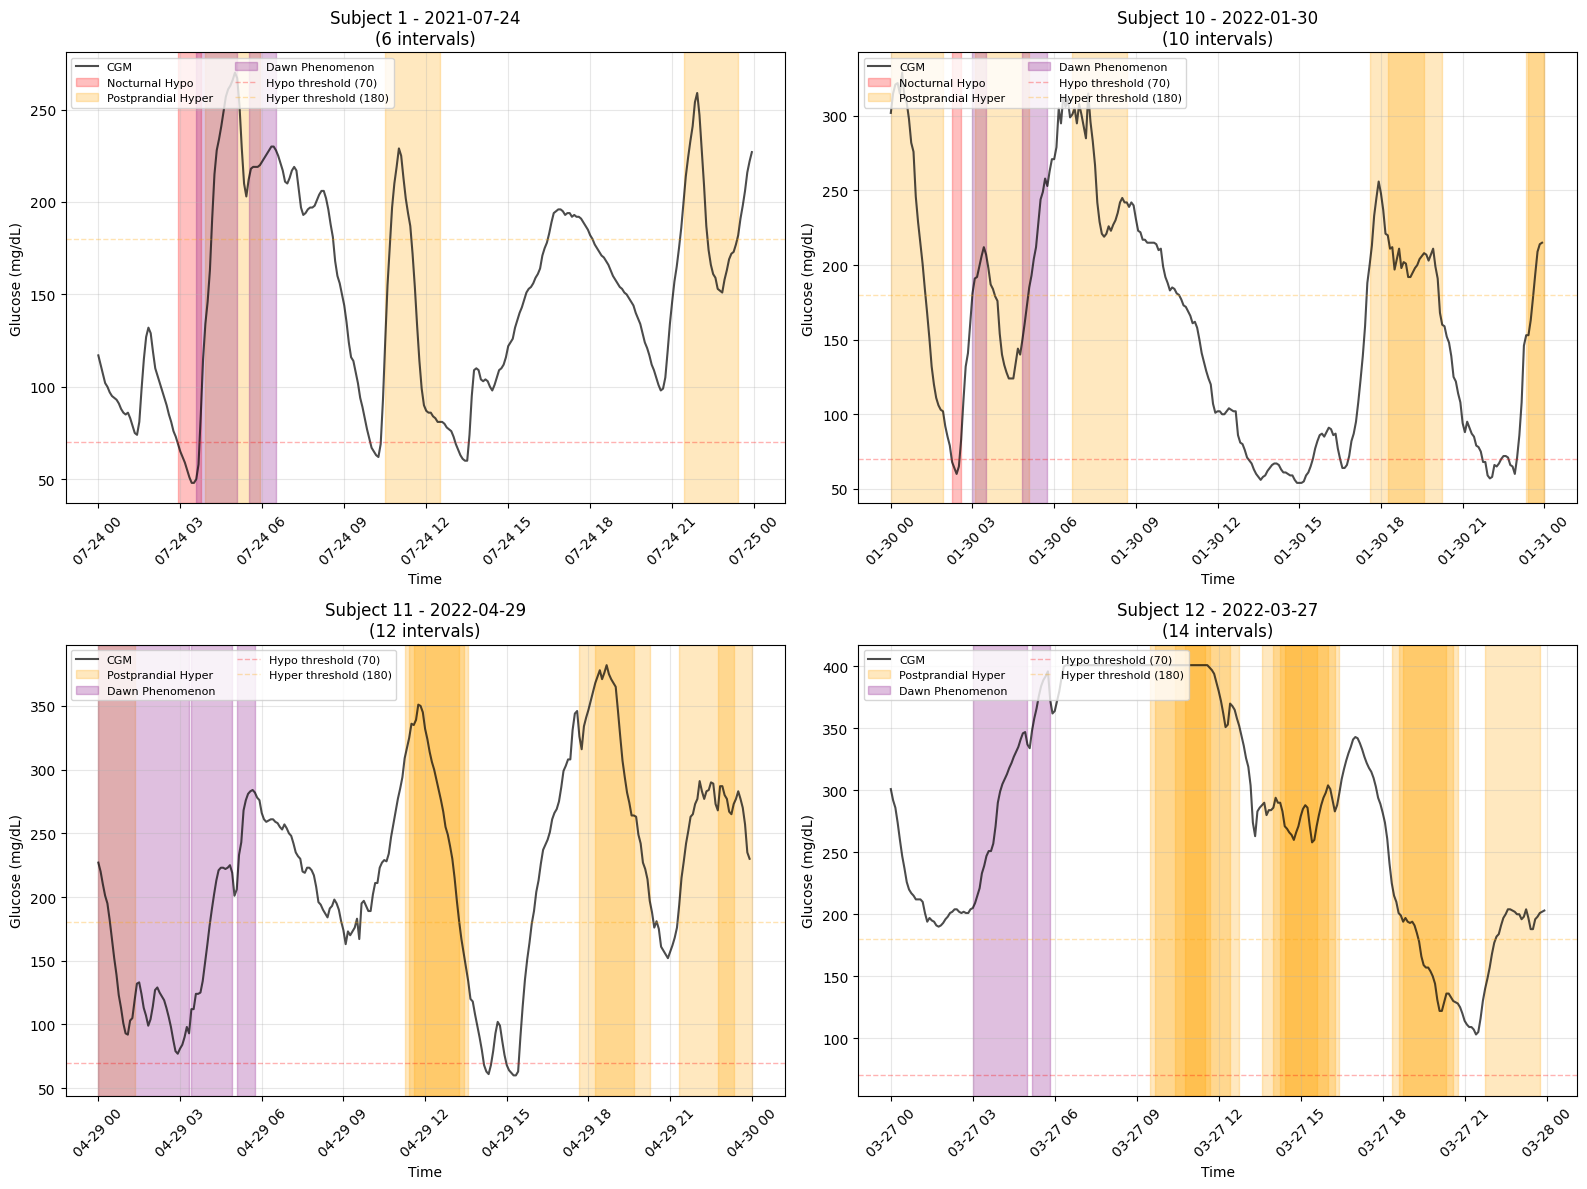


SUMMARY

Subject 1:
  Day with most intervals: 2021-07-24
  Total intervals: 6
  Pattern breakdown:
    - Nocturnal Hypo: 1
    - Postprandial Hyper: 3
    - Dawn Phenomenon: 2
  Intervals on this day:
    - Nocturnal Hypo: 1 interval(s)
      [1] 02:55 - 03:45
    - Postprandial Hyper: 3 interval(s)
      [1] 03:55 - 05:55
      [2] 10:30 - 12:30
      [3] 21:25 - 23:25
    - Dawn Phenomenon: 2 interval(s)
      [1] 03:35 - 05:05
      [2] 05:30 - 06:30

Subject 10:
  Day with most intervals: 2022-01-30
  Total intervals: 10
  Pattern breakdown:
    - Nocturnal Hypo: 1
    - Postprandial Hyper: 7
    - Dawn Phenomenon: 2
  Intervals on this day:
    - Nocturnal Hypo: 1 interval(s)
      [1] 02:15 - 02:35
    - Postprandial Hyper: 7 interval(s)
      [1] 00:00 - 01:55
      [2] 03:05 - 05:05
      [3] 06:40 - 08:40
      ... and 4 more
    - Dawn Phenomenon: 2 interval(s)
      [1] 03:00 - 03:30
      [2] 04:50 - 05:45

Subject 11:
  Day with most intervals: 2022-04-29
  Total interva

In [ ]:
def clip_interval_to_day(start_time, end_time, target_day):
    """Clip an interval to the target day boundaries."""
    day_start = pd.Timestamp(target_day).replace(hour=0, minute=0, second=0)
    day_end = day_start + pd.Timedelta(days=1)
    
    # Clip start and end to day boundaries
    clipped_start = max(start_time, day_start)
    clipped_end = min(end_time, day_end)
    
    # Only return if there's a valid interval
    if clipped_start < clipped_end:
        return clipped_start, clipped_end
    return None, None

def get_intervals_for_day(events, target_day):
    """Get all intervals that overlap with the target day, clipped to day boundaries."""
    day_intervals = []
    day_start = pd.Timestamp(target_day).replace(hour=0, minute=0, second=0)
    day_end = day_start + pd.Timedelta(days=1)
    
    for start_time, end_time in events:
        # Convert to Timestamp if needed
        if not isinstance(start_time, pd.Timestamp):
            start_time = pd.to_datetime(start_time)
        if not isinstance(end_time, pd.Timestamp):
            end_time = pd.to_datetime(end_time)
        
        # Check if interval overlaps with target day
        if end_time > day_start and start_time < day_end:
            # Clip to day boundaries
            clipped_start, clipped_end = clip_interval_to_day(start_time, end_time, target_day)
            if clipped_start is not None:
                day_intervals.append((clipped_start, clipped_end))
    
    return day_intervals

# Get first 4 subjects
first_4_subjects = list(subjects_dict.keys())[:4]
print(f"Analyzing subjects: {first_4_subjects}")

# For each subject, find the day with most intervals
subject_days_data = {}

for sid in first_4_subjects:
    df = subjects_dict[sid]
    
    # Detect all patterns
    hypo_events = detect_nocturnal_hypo(df)
    hyper_events = detect_postprandial_hyper(df)
    dawn_events = detect_dawn_phenomenon(df)
    missed_events = detect_missed_bolus(df)
    
    # Combine all events
    all_events = {
        'nocturnal_hypo': hypo_events,
        'postprandial_hyper': hyper_events,
        'dawn_phenomenon': dawn_events,
        'missed_bolus': missed_events
    }
    
    # Count intervals per day (count unique intervals that touch each day)
    day_counts = {}
    for pattern_name, events in all_events.items():
        for start_time, end_time in events:
            # Convert to Timestamp if needed
            if not isinstance(start_time, pd.Timestamp):
                start_time = pd.to_datetime(start_time)
            if not isinstance(end_time, pd.Timestamp):
                end_time = pd.to_datetime(end_time)
            
            # Get all days this interval touches
            current_date = start_time.date()
            end_date = end_time.date()
            
            # Count interval for each day it touches
            while current_date <= end_date:
                if current_date not in day_counts:
                    day_counts[current_date] = {'total': 0, 'patterns': {}}
                day_counts[current_date]['total'] += 1
                if pattern_name not in day_counts[current_date]['patterns']:
                    day_counts[current_date]['patterns'][pattern_name] = 0
                day_counts[current_date]['patterns'][pattern_name] += 1
                current_date += timedelta(days=1)
    
    # Find day(s) with most intervals
    if day_counts:
        max_count = max(day_counts.values(), key=lambda x: x['total'])['total']
        top_days = [day for day, data in day_counts.items() if data['total'] == max_count]
        
        # Use the first top day if multiple days have same count
        top_day = top_days[0]
        
        # Get intervals for this specific day (clipped to day boundaries)
        day_intervals = {}
        for pattern_name, events in all_events.items():
            intervals = get_intervals_for_day(events, top_day)
            if intervals:
                day_intervals[pattern_name] = intervals
        
        subject_days_data[sid] = {
            'top_day': top_day,
            'interval_count': max_count,
            'pattern_counts': day_counts[top_day]['patterns'],
            'day_intervals': day_intervals  # Intervals clipped to this day
        }
        
        print(f"\nSubject {sid}:")
        print(f"  Top day: {top_day}")
        print(f"  Total intervals: {max_count}")
        print(f"  Pattern breakdown: {day_counts[top_day]['patterns']}")
    else:
        print(f"\nSubject {sid}: No pattern intervals detected")

# Plot the most popular days
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Color mapping for different patterns
pattern_colors = {
    'nocturnal_hypo': 'red',
    'postprandial_hyper': 'orange',
    'dawn_phenomenon': 'purple',
    'missed_bolus': 'blue'
}

for idx, sid in enumerate(first_4_subjects):
    if sid not in subject_days_data:
        axes[idx].text(0.5, 0.5, f'Subject {sid}\nNo data available', 
                      ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f'Subject {sid} - No Data')
        continue
    
    data = subject_days_data[sid]
    top_day = data['top_day']
    day_intervals = data['day_intervals']
    
    # Get data for this day
    df = subjects_dict[sid]
    day_data = df[df.index.date == top_day]
    
    if len(day_data) == 0:
        axes[idx].text(0.5, 0.5, f'Subject {sid}\nNo data for {top_day}', 
                      ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f'Subject {sid} - {top_day}')
        continue
    
    # Plot CGM
    axes[idx].plot(
        day_data.index,
        day_data['cgm'],
        color='black',
        linewidth=1.5,
        alpha=0.7,
        label='CGM'
    )
    
    # Highlight pattern intervals (using clipped intervals for this day)
    labels_added = set()  # Track which labels we've added to avoid duplicates
    for pattern_name, intervals in day_intervals.items():
        color = pattern_colors.get(pattern_name, 'gray')
        label = pattern_name.replace('_', ' ').title()
        
        for start_time, end_time in intervals:
            # Only add label once per pattern type
            if label not in labels_added:
                axes[idx].axvspan(
                    start_time, end_time,
                    color=color,
                    alpha=0.25,
                    label=label
                )
                labels_added.add(label)
            else:
                axes[idx].axvspan(
                    start_time, end_time,
                    color=color,
                    alpha=0.25
                )
    
    # Add reference lines for glucose ranges
    axes[idx].axhline(y=70, color='red', linestyle='--', alpha=0.3, linewidth=1, label='Hypo threshold (70)')
    axes[idx].axhline(y=180, color='orange', linestyle='--', alpha=0.3, linewidth=1, label='Hyper threshold (180)')
    
    axes[idx].set_xlabel('Time')
    axes[idx].set_ylabel('Glucose (mg/dL)')
    axes[idx].set_title(f'Subject {sid} - {top_day}\n({data["interval_count"]} intervals)')
    axes[idx].legend(loc='upper left', fontsize=8, ncol=2)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
for sid in first_4_subjects:
    if sid in subject_days_data:
        data = subject_days_data[sid]
        print(f"\nSubject {sid}:")
        print(f"  Day with most intervals: {data['top_day']}")
        print(f"  Total intervals: {data['interval_count']}")
        print(f"  Pattern breakdown:")
        for pattern, count in data['pattern_counts'].items():
            print(f"    - {pattern.replace('_', ' ').title()}: {count}")
        print(f"  Intervals on this day:")
        for pattern, intervals in data['day_intervals'].items():
            if intervals:
                print(f"    - {pattern.replace('_', ' ').title()}: {len(intervals)} interval(s)")
                for i, (start, end) in enumerate(intervals[:3]):  # Show first 3
                    print(f"      [{i+1}] {start.strftime('%H:%M')} - {end.strftime('%H:%M')}")
                if len(intervals) > 3:
                    print(f"      ... and {len(intervals)-3} more")



## 4. Extract day‑level features and perform clustering

To discover recurring glycemic behaviors across participants, we extract features summarizing each subject‑day and apply k‑means clustering. Features include daily glycemic metrics, counts of detected patterns, and total carb and bolus amounts. We standardize features and cluster them into k clusters.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Merge daily metrics with pattern counts and daily totals
def build_feature_table(subjects_dict, daily_metrics, pattern_counts):
    pattern_df = pd.DataFrame(pattern_counts)
    feature_rows = []
    for _, row in daily_metrics.iterrows():
        sid = row['subject_id']
        date = row['date']
        counts_row = pattern_df[pattern_df['subject_id'] == sid]
        if not counts_row.empty:
            counts = counts_row.iloc[0]
        else:
            counts = {'nocturnal_hypo_count': 0, 'postprandial_hyper_count': 0,
                      'dawn_phenomenon_count': 0, 'missed_bolus_count': 0}
        df = subjects_dict[sid]
        totals = df[df.index.date == date].agg({'carbInput': 'sum', 'normal': 'sum'})
        feature_rows.append({
            'subject_id': sid,
            'date': date,
            'TIR_percent': row['TIR_percent'],
            'TBR_percent': row['TBR_percent'],
            'TAR_percent': row['TAR_percent'],
            'mean_glucose': row['mean_glucose'],
            'sd_glucose': row['sd_glucose'],
            'cv': row['cv'],
            'nocturnal_hypo_count': counts['nocturnal_hypo_count'],
            'postprandial_hyper_count': counts['postprandial_hyper_count'],
            'dawn_phenomenon_count': counts['dawn_phenomenon_count'],
            'missed_bolus_count': counts['missed_bolus_count'],
            'total_carb_input': totals['carbInput'],
            'total_normal': totals['normal'],
        })
    return pd.DataFrame(feature_rows)

feature_table = build_feature_table(subjects_dict, subject_daily_metrics, pattern_counts)

# Standardize numeric features
features_numeric = feature_table.drop(columns=['subject_id','date'])
scaler = StandardScaler()
scaled = scaler.fit_transform(features_numeric)

# Cluster days
# k = 3
# kmeans = KMeans(n_clusters=k, random_state=42)
# feature_table['cluster'] = kmeans.fit_predict(scaled)
# feature_table[['subject_id','date','cluster']].head()


KeyboardInterrupt: 

## 5. Build forecasting models: global vs. patient‑specific

Construct supervised datasets with lagged predictors and train an XGBoost regressor. Two strategies are used:
1. A global model that learns from all subjects with subject ID one‑hot encoded.
2. Fine‑tuning the global model on each subject’s data for personalization.
We evaluate each by mean squared error (MSE) per subject.

## What is lag and what it should be?

A lag means "the value from the past".

If we are at 10:10:
- cgm_lag_1 = CGM at 10:05 (125)
- cgm_lag_2 = CGM at 10:00 (120)

So lags let the model see recent history instead of only the current moment. Without lags, the model would see only:
`current carbs, current bolus, current basal -> current glucose`

### What lag should be?
I found some such information from research papers:
|Effect|Typical delay|
|-|-|
|Rapid-acting insulin|30-120 min
|Carbohydrate absorption|20-90 min
|CGM sensor lag|~5-10 min|

So better to choose something like 12 or 18 lags 60 or 90 minutes acordingly.


In [ ]:
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from scipy.sparse import hstack

N_LAGS = 12
MIN_TRAIN_SAMPLES = 500  # Minimum samples needed for fine-tuning
TEMPORAL_GAP_DAYS = 7  # Gap between train and test to prevent temporal leakage

# Build supervised dataset with lagged features
def build_supervised_for_all(subjects_dict, n_lags=12, include_subject_id=True, normalize=False):
    X_list, y_list = [], []
    sid_list = []
    scalers = {}
    
    for sid, df in subjects_dict.items():
        data = df.copy().sort_index()  # Ensure sorted by time
        
        # Create lag features
        for i in range(1, n_lags + 1):
            data[f'cgm_lag_{i}'] = data['cgm'].shift(i)
            data[f'carb_lag_{i}'] = data['carbInput'].shift(i)
            data[f'bolus_lag_{i}'] = data['normal'].shift(i)
            data[f'basal_lag_{i}'] = data['basal_rate'].shift(i)
        
        data = data.dropna()
        
        # Extract features
        feature_cols = ([f'cgm_lag_{i}' for i in range(1, n_lags + 1)] +
                       [f'carb_lag_{i}' for i in range(1, n_lags + 1)] +
                       [f'bolus_lag_{i}' for i in range(1, n_lags + 1)] +
                       [f'basal_lag_{i}' for i in range(1, n_lags + 1)])
        
        X_subj = data[feature_cols].copy()
        y_subj = data['cgm'].copy()
        
        # Per-subject normalization if requested
        if normalize:
            scaler_X = StandardScaler()
            scaler_y = StandardScaler()
            X_subj = pd.DataFrame(
                scaler_X.fit_transform(X_subj),
                columns=feature_cols,
                index=X_subj.index
            )
            y_subj = pd.Series(
                scaler_y.fit_transform(y_subj.values.reshape(-1, 1)).ravel(),
                index=y_subj.index
            )
            scalers[sid] = {'X': scaler_X, 'y': scaler_y}
        
        X_list.append(X_subj)
        y_list.append(y_subj)
        sid_list.append(pd.Series([sid] * len(X_subj), index=X_subj.index))
    
    X_all = pd.concat(X_list, axis=0)
    y_all = pd.concat(y_list, axis=0)
    sid_all = pd.concat(sid_list, axis=0)
    
    if include_subject_id:
        X_all['subject_id'] = sid_all.values
    
    return X_all.reset_index(drop=True), y_all.reset_index(drop=True), scalers

# Build dataset
X_all, y_all, scalers = build_supervised_for_all(
    subjects_dict, 
    n_lags=N_LAGS, 
    include_subject_id=False,
    normalize=False  # Set to True for per-subject normalization
)

print(f"Total samples: {len(X_all)}, Features: {X_all.shape[1]}")

# Subject-level splitting to prevent leakage (each subject entirely in train or test)
def split_by_subject(subjects_dict, n_lags=12, train_ratio=0.8):
    subject_ids = list(subjects_dict.keys())
    np.random.seed(42)
    np.random.shuffle(subject_ids)
    
    n_train_subjects = int(train_ratio * len(subject_ids))
    train_subject_ids = set(subject_ids[:n_train_subjects])
    test_subject_ids = set(subject_ids[n_train_subjects:])
    
    train_indices = []
    test_indices = []
    offset = 0
    subject_boundaries = {}
    
    for sid, df in subjects_dict.items():
        df_sorted = df.sort_index()
        length = len(df_sorted) - n_lags
        
        if length <= 0:
            continue
        
        # Assign entire subject to train or test
        if sid in train_subject_ids:
            subject_train_idx = np.arange(offset, offset + length)
            subject_test_idx = np.array([], dtype=int)
        else:  # sid in test_subject_ids
            subject_train_idx = np.array([], dtype=int)
            subject_test_idx = np.arange(offset, offset + length)
        
        train_indices.extend(subject_train_idx)
        test_indices.extend(subject_test_idx)
        
        subject_boundaries[sid] = {
            'start': offset,
            'end': offset + length,
            'train_count': len(subject_train_idx),
            'test_count': len(subject_test_idx),
            'in_train': sid in train_subject_ids,
            'in_test': sid in test_subject_ids
        }
        
        offset += length
    
    return np.array(train_indices), np.array(test_indices), subject_boundaries

train_idx, test_idx, subject_boundaries = split_by_subject(
    subjects_dict, 
    n_lags=N_LAGS,
    train_ratio=0.8
)

print(f"Train samples: {len(train_idx)}, Test samples: {len(test_idx)}")

def verify_no_subject_leakag(subject_boundaries):
    train_subjects = set()
    test_subjects = set()
    for sid, bounds in subject_boundaries.items():
        train_subj_idx = [i for i in train_idx if bounds['start'] <= i < bounds['end']]
        test_subj_idx = [i for i in test_idx if bounds['start'] <= i < bounds['end']]
        if len(train_subj_idx) > 0:
            train_subjects.add(sid)
        if len(test_subj_idx) > 0:
            test_subjects.add(sid)

    assert len(train_subjects & test_subjects) == 0, "ERROR: Subject leakage detected!"
    print("GOOD: No subject leakage detected")

# Prepare features with subject ID encoding (recommended)
# enc = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
# subject_ids = X_all[['subject_id']].astype(str)
# subject_ohe = enc.fit_transform(subject_ids)
# X_numeric = X_all.drop(columns=['subject_id'])
# X_global = hstack([X_numeric.values, subject_ohe]).tocsr()
X_global = X_all.values


# Global model hyperparameters
params_global = {
    'n_estimators': 300,
    'max_depth': 4,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.0,  # L1 regularization
    'reg_lambda': 0.1,  # L2 regularization
    'objective': 'reg:squarederror',
    'random_state': 42,
    'tree_method': 'hist',  # Required for sparse matrices
}

print("\nTraining global XGBoost model...")
xgb_global = xgb.XGBRegressor(**params_global)
xgb_global.fit(X_global[train_idx], y_all.iloc[train_idx])

preds_global = xgb_global.predict(X_global[test_idx])
mse_global = mean_squared_error(y_all.iloc[test_idx], preds_global)
mae_global = mean_absolute_error(y_all.iloc[test_idx], preds_global)

print(f"Global Model - Test MSE: {mse_global:.2f}, MAE: {mae_global:.2f}")

results = []
test_idx_pos = {idx: pos for pos, idx in enumerate(test_idx)}

for sid, bounds in subject_boundaries.items():
    subj_test_idx = [i for i in test_idx if bounds['start'] <= i < bounds['end']]
    if len(subj_test_idx) == 0:
        continue
    
    subj_test_pos = [test_idx_pos[i] for i in subj_test_idx]
    y_true = y_all.iloc[subj_test_idx].values
    y_pred = preds_global[subj_test_pos]
    
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    
    results.append({
        'subject_id': sid,
        'global_mse': mse,
        'global_mae': mae,
        'n_test_points': len(y_true)
    })

results_df = pd.DataFrame(results)
print(f"\nGlobal model results per subject:")
print(results_df.describe())
results_df

Total samples: 7286982, Features: 48
Train samples: 5520212, Test samples: 1766770
✓ No subject leakage detected

Training global XGBoost model...
Global Model - Test MSE: 44.75, MAE: 3.89

Global model results per subject:
       subject_id  global_mse  global_mae  n_test_points
count   11.000000   11.000000   11.000000      11.000000
mean    23.363636   41.058038    3.836983  160615.454545
std     14.698794   14.384083    0.531678  148776.066274
min      3.000000   20.834584    2.934634   11782.000000
25%     12.500000   30.360151    3.521181   45434.000000
50%     22.000000   41.452711    3.820979  111494.000000
75%     31.500000   46.405151    4.222637  268605.000000
max     48.000000   68.018805    4.650646  397821.000000


,subject_id,global_mse,global_mae,n_test_points
0,16,42.289093,3.820979,206947
1,19,20.834584,2.934634,135272
2,22,30.703696,3.470280,111494
3,26,61.474224,4.650646,73082
4,28,26.789804,3.224257,59912
5,3,68.018805,4.205108,397821
6,35,48.669256,4.508948,30956
7,44,44.141045,3.879718,16930
8,48,30.016607,3.572082,11782
9,7,37.248596,3.699996,392311


In [6]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full width of text fields

Best subject: 19.0
Worst subject: 26.0


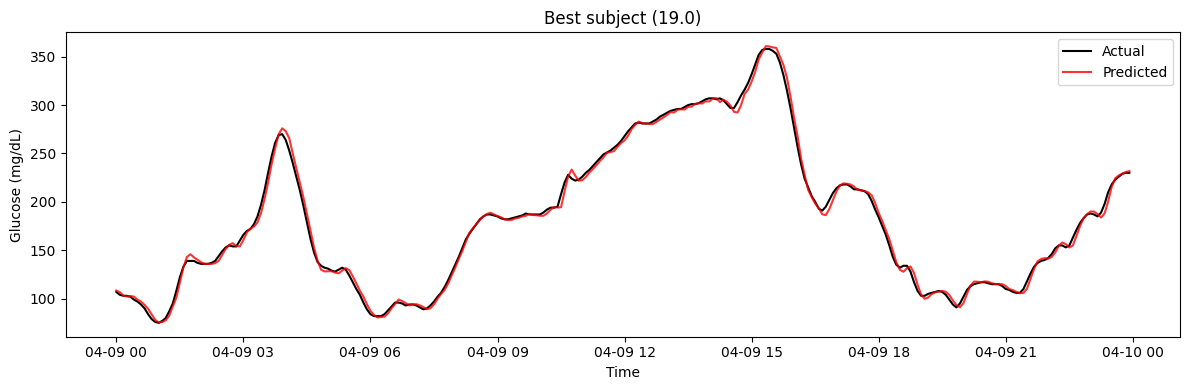

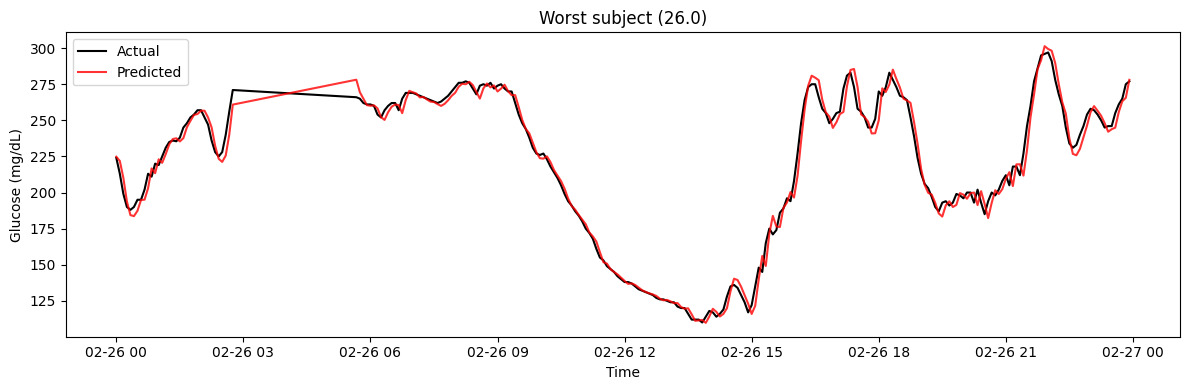

In [9]:
best_subject = results_df.sort_values("global_mae").iloc[0]["subject_id"]
worst_subject = results_df.sort_values("global_mae").iloc[-1]["subject_id"]

print("Best subject:", best_subject)
print("Worst subject:", worst_subject)

def get_subject_predictions(
    sid,
    subjects_dict,
    subject_boundaries,
    test_idx,
    preds_global,
    y_all,
    n_lags
):
    bounds = subject_boundaries[sid]

    # indices belonging to this subject AND test set
    subj_test_idx = [i for i in test_idx if bounds['start'] <= i < bounds['end']]
    if len(subj_test_idx) == 0:
        return None

    # map to prediction positions
    test_idx_pos = {idx: pos for pos, idx in enumerate(test_idx)}
    subj_test_pos = [test_idx_pos[i] for i in subj_test_idx]

    # original dataframe
    df = subjects_dict[sid].sort_index()

    # after lagging, targets start at index n_lags
    time_index = df.index[n_lags:]

    out = pd.DataFrame(
        {
            "actual": y_all.iloc[subj_test_idx].values,
            "predicted": preds_global[subj_test_pos],
        },
        index=time_index[subj_test_idx[0] - bounds["start"] :
                         subj_test_idx[-1] - bounds["start"] + 1]
    )

    return out

def pick_one_day(df_pred):
    df_pred["date"] = df_pred.index.date
    day_counts = df_pred.groupby(df_pred.index.date).size()
    full_day = day_counts[day_counts >= 200].index[0]  # ~1 day of 5-min CGM
    return df_pred[df_pred["date"] == full_day].drop(columns="date")

def plot_actual_vs_predicted(df_day, title):
    plt.figure(figsize=(12, 4))

    plt.plot(
        df_day.index,
        df_day["actual"],
        label="Actual",
        color="black",
        linewidth=1.5
    )

    plt.plot(
        df_day.index,
        df_day["predicted"],
        label="Predicted",
        color="red",
        linewidth=1.5,
        alpha=0.8
    )

    plt.ylabel("Glucose (mg/dL)")
    plt.xlabel("Time")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Best subject
best_pred = get_subject_predictions(
    best_subject,
    subjects_dict,
    subject_boundaries,
    test_idx,
    preds_global,
    y_all,
    N_LAGS
)

best_day = pick_one_day(best_pred)
plot_actual_vs_predicted(
    best_day,
    f"Best subject ({best_subject})"
)

# Worst subject
worst_pred = get_subject_predictions(
    worst_subject,
    subjects_dict,
    subject_boundaries,
    test_idx,
    preds_global,
    y_all,
    N_LAGS
)

worst_day = pick_one_day(worst_pred)
plot_actual_vs_predicted(
    worst_day,
    f"Worst subject ({worst_subject})"
)


### 5.1 Personalize the global model

Fine‑tune the global model separately for each subject using their own training data. We continue training from the global booster for a small number of rounds and evaluate on that subject’s test set.

In [ ]:
# # Fine-tune global model per subject with proper regularization and early stopping
# print("="*60)
# print("Fine-tuning global model per subject...")
# print("="*60)

# # Hyperparameters for fine-tuning (more conservative than global)
# params_finetune = {
#     'n_estimators': 50,  # Additional trees (will be added to global model's 300)
#     'max_depth': 3,  # Shallower to prevent overfitting
#     'learning_rate': 0.01,  # Lower LR for careful adaptation
#     'subsample': 0.7,  # More aggressive subsampling
#     'colsample_bytree': 0.7,
#     'reg_alpha': 0.1,  # More L1 regularization
#     'reg_lambda': 1.0,  # More L2 regularization
#     'min_child_weight': 5,  # Require more samples per leaf
#     'objective': 'reg:squarederror',
#     'random_state': 42,
# }

# results_personalized = []

# for sid, df in subjects_dict.items():
#     print(f"\nProcessing Subject {sid}...")
    
#     # Build subject-specific dataset (without subject_id for fine-tuning)
#     X_subj, y_subj, _ = build_supervised_for_all(
#         {sid: df}, 
#         n_lags=N_LAGS, 
#         include_subject_id=False,
#         normalize=False  # Match global model normalization
#     )
    
#     if len(X_subj) < MIN_TRAIN_SAMPLES:
#         print(f"  Insufficient data ({len(X_subj)} samples < {MIN_TRAIN_SAMPLES}), using global model")
#         global_result = results_df[results_df['subject_id'] == sid]
#         if not global_result.empty:
#             results_personalized.append({
#                 'subject_id': sid,
#                 'global_mse': global_result['global_mse'].values[0],
#                 'personalized_mse': global_result['global_mse'].values[0],
#                 'global_mae': global_result['global_mae'].values[0],
#                 'personalized_mae': global_result['global_mae'].values[0],
#                 'fine_tuned': False,
#                 'n_train_samples': len(X_subj),
#                 'overfit_ratio': np.nan
#             })
#         continue
    
#     # Split: 60% train, 20% val, 20% test (for early stopping)
#     train_end = int(0.6 * len(X_subj))
#     val_end = int(0.8 * len(X_subj))
    
#     X_train_subj = X_subj.iloc[:train_end]
#     y_train_subj = y_subj.iloc[:train_end]
#     X_val_subj = X_subj.iloc[train_end:val_end]
#     y_val_subj = y_subj.iloc[train_end:val_end]
#     X_test_subj = X_subj.iloc[val_end:]
#     y_test_subj = y_subj.iloc[val_end:]
    
#     print(f"  Train: {len(X_train_subj)}, Val: {len(X_val_subj)}, Test: {len(X_test_subj)}")
    
#     # Fine-tune with manual early stopping (early_stopping_rounds not supported with xgb_model)
#     xgb_personal = xgb.XGBRegressor(**params_finetune)
    
#     try:
#         # When using xgb_model to continue training, early_stopping_rounds may not be supported
#         # So we'll train without it (with only 50 trees and regularization, overfitting risk is low)
#         xgb_personal.fit(
#             X_train_subj, y_train_subj,
#             eval_set=[(X_val_subj, y_val_subj)],
#             verbose=False,
#             xgb_model=xgb_global.get_booster()  # Continue from global model
#         )
#     except Exception as e:
#         print(f"  Error during fine-tuning: {e}, using global model")
#         global_result = results_df[results_df['subject_id'] == sid]
#         if not global_result.empty:
#             results_personalized.append({
#                 'subject_id': sid,
#                 'global_mse': global_result['global_mse'].values[0],
#                 'personalized_mse': global_result['global_mse'].values[0],
#                 'fine_tuned': False,
#                 'error': str(e)
#             })
#         continue
    
#     # Evaluate on test set
#     preds_test = xgb_personal.predict(X_test_subj)
#     mse_test = mean_squared_error(y_test_subj, preds_test)
#     mae_test = mean_absolute_error(y_test_subj, preds_test)
    
#     # Also evaluate on train to check for overfitting
#     preds_train = xgb_personal.predict(X_train_subj)
#     mse_train = mean_squared_error(y_train_subj, preds_train)
    
#     # Get global model performance for this subject
#     # Evaluate global model on this subject's test set for fair comparison
#     # This works for all subjects (both train and test set subjects)
#     # since we're evaluating on each subject's own test set
#     try:
#         preds_global_test = xgb_global.predict(X_test_subj)
#         global_mse = mean_squared_error(y_test_subj, preds_global_test)
#         global_mae = mean_absolute_error(y_test_subj, preds_global_test)
#     except Exception as e:
#         # If there's an error (e.g., feature mismatch), try to get from results_df
#         # This handles edge cases where evaluation fails
#         print(f"  Warning: Error evaluating global model: {e}")
#         global_result = results_df[results_df['subject_id'] == sid]
#         if not global_result.empty:
#             global_mse = global_result['global_mse'].values[0]
#             global_mae = global_result['global_mae'].values[0]
#             print(f"  Using global model results from results_df")
#         else:
#             # Subject not in test set and evaluation failed
#             print(f"  Cannot evaluate global model for subject {sid}")
#             global_mse = np.nan
#             global_mae = np.nan
    
#     # Calculate overfitting ratio (train MSE / test MSE)
#     # Ratio < 0.5 indicates possible overfitting
#     overfit_ratio = mse_train / mse_test if mse_test > 0 else np.inf
    
#     improvement = ((global_mse - mse_test) / global_mse * 100) if global_mse > 0 else 0
    
#     print(f"  Global MSE: {global_mse:.2f}, Personalized MSE: {mse_test:.2f} ({improvement:+.1f}%)")
#     print(f"  Train MSE: {mse_train:.2f}, Overfit ratio: {overfit_ratio:.2f}")
    
#     if overfit_ratio < 0.5:
#         print(f"    WARNING: Possible overfitting (train MSE much lower than test MSE)")
    
#     results_personalized.append({
#         'subject_id': sid,
#         'global_mse': global_mse,
#         'personalized_mse': mse_test,
#         'global_mae': global_mae,
#         'personalized_mae': mae_test,
#         'train_mse': mse_train,
#         'overfit_ratio': overfit_ratio,
#         'improvement_pct': improvement,
#         'fine_tuned': True,
#         'n_train_samples': len(X_train_subj),
#         'n_val_samples': len(X_val_subj),
#         'n_test_samples': len(X_test_subj)
#     })

# personalized_results_df = pd.DataFrame(results_personalized)

# # Summary
# print("\n" + "="*60)
# print("FINE-TUNING SUMMARY")
# print("="*60)

# print(f"\nTotal subjects processed: {len(personalized_results_df)}")
# print(f"Subjects fine-tuned: {personalized_results_df['fine_tuned'].sum()}")
# print(f"Subjects using global model: {(~personalized_results_df['fine_tuned']).sum()}")

# if personalized_results_df['fine_tuned'].sum() > 0:
#     fine_tuned = personalized_results_df[personalized_results_df['fine_tuned']]
    
#     print(f"\n--- Fine-Tuned Subjects ---")
#     print(f"Average improvement: {fine_tuned['improvement_pct'].mean():.2f}%")
#     print(f"Subjects improved: {(fine_tuned['personalized_mse'] < fine_tuned['global_mse']).sum()}")
#     print(f"Subjects worsened: {(fine_tuned['personalized_mse'] > fine_tuned['global_mse']).sum()}")
#     print(f"Average overfit ratio: {fine_tuned['overfit_ratio'].mean():.2f}")
#     print(f"Subjects with overfitting (ratio < 0.5): {(fine_tuned['overfit_ratio'] < 0.5).sum()}")
    
#     print(f"\n--- Performance Comparison ---")
#     print(f"Global Model - Mean MSE: {fine_tuned['global_mse'].mean():.2f}")
#     print(f"Personalized Model - Mean MSE: {fine_tuned['personalized_mse'].mean():.2f}")
#     print(f"Global Model - Mean MAE: {fine_tuned['global_mae'].mean():.2f}")
#     print(f"Personalized Model - Mean MAE: {fine_tuned['personalized_mae'].mean():.2f}")

# print("\n" + "="*60)
# print("Detailed Results:")
# print("="*60)
# personalized_results_df


Fine-tuning global model per subject...

Processing Subject 1...
  Train: 265247, Val: 88416, Test: 88416
  Global MSE: 35.38, Personalized MSE: 35.50 (-0.3%)
  Train MSE: 71.88, Overfit ratio: 2.02

Processing Subject 10...
  Train: 187943, Val: 62648, Test: 62648
  Global MSE: 54.03, Personalized MSE: 53.74 (+0.5%)
  Train MSE: 47.06, Overfit ratio: 0.88

Processing Subject 11...
  Train: 177732, Val: 59244, Test: 59245
  Global MSE: 66.17, Personalized MSE: 65.82 (+0.5%)
  Train MSE: 69.29, Overfit ratio: 1.05

Processing Subject 12...
  Train: 177277, Val: 59092, Test: 59093
  Global MSE: 37.54, Personalized MSE: 37.57 (-0.1%)
  Train MSE: 46.69, Overfit ratio: 1.24

Processing Subject 13...
  Train: 139456, Val: 46485, Test: 46486
  Global MSE: 42.23, Personalized MSE: 43.71 (-3.5%)
  Train MSE: 35.27, Overfit ratio: 0.81

Processing Subject 14...
  Train: 122020, Val: 40674, Test: 40674
  Global MSE: 44.31, Personalized MSE: 44.33 (-0.1%)
  Train MSE: 41.37, Overfit ratio: 0.93



,subject_id,global_mse,personalized_mse,global_mae,personalized_mae,train_mse,overfit_ratio,improvement_pct,fine_tuned,n_train_samples,n_val_samples,n_test_samples
0,1,35.375728,35.496652,3.557765,3.559130,71.875295,2.024847,-0.341827,True,265247,88416,88416
1,10,54.026895,53.740497,4.487198,4.466447,47.062701,0.875740,0.530103,True,187943,62648,62648
2,11,66.169046,65.817718,5.101604,5.079435,69.294317,1.052822,0.530955,True,177732,59244,59245
3,12,37.536521,37.569709,3.921268,3.918306,46.693348,1.242846,-0.088417,True,177277,59092,59093
4,13,42.229208,43.705644,4.032957,4.107479,35.267436,0.806931,-3.496244,True,139456,46485,46486
5,14,44.309804,44.332788,4.153507,4.168260,41.371786,0.933210,-0.051872,True,122020,40674,40674
6,15,32.478098,32.843290,3.656084,3.674431,38.093369,1.159852,-1.124426,True,127914,42638,42638
7,16,55.269960,55.153189,4.480691,4.502671,33.047344,0.599192,0.211274,True,124168,41389,41390
8,17,58.480076,58.268602,4.606799,4.604926,46.886615,0.804663,0.361616,True,112308,37436,37437
9,18,38.632869,38.822549,3.739861,3.748915,37.584588,0.968112,-0.490982,True,91295,30432,30432


## 6. Generate patient‑friendly insights

Use the pattern counts to produce brief plain‑language summaries for each subject. These messages should be reviewed by clinicians before being shared.

In [10]:
def generate_insights(hypo_events, hyper_events, dawn_events, missed_events):
    messages = []
    if hypo_events:
        count = len(hypo_events)
        messages.append(f"You had nocturnal hypoglycemia {count} time{'s' if count>1 else ''}. Discuss overnight basal settings with your care team.")
    if hyper_events:
        count = len(hyper_events)
        messages.append(f"Your glucose rose above 180 mg/dL after meals {count} time{'s' if count>1 else ''}. Consider reviewing carb counting or mealtime insulin.")
    if dawn_events:
        count = len(dawn_events)
        messages.append(f"A dawn phenomenon was observed {count} time{'s' if count>1 else ''}. You may need to adjust basal rates overnight.")
    if missed_events:
        count = len(missed_events)
        messages.append(f"There were {count} meals with carbs but no bolus insulin. Make sure to bolus for meals.")
    if not messages:
        messages.append("No clinically concerning patterns detected. Keep up the good work!")
    return messages

# Example insights for first subject
sid_example = list(subjects_dict.keys())[0]
example_df = subjects_dict[sid_example]
insights_example = generate_insights(
    detect_nocturnal_hypo(example_df),
    detect_postprandial_hyper(example_df),
    detect_dawn_phenomenon(example_df),
    detect_missed_bolus(example_df)
)
print(f"Insights for subject {sid_example}:")
for msg in insights_example:
    print('-', msg)


Insights for subject 1:
- You had nocturnal hypoglycemia 336 times. Discuss overnight basal settings with your care team.
- Your glucose rose above 180 mg/dL after meals 175 times. Consider reviewing carb counting or mealtime insulin.
- A dawn phenomenon was observed 943 times. You may need to adjust basal rates overnight.
- There were 2 meals with carbs but no bolus insulin. Make sure to bolus for meals.


## 8. Predictive risk modeling and decision support

In this section we extend the system to provide prediction‑aware insights. Instead of only summarizing past patterns, we train classification models to estimate the risk of upcoming hypoglycemia or hyperglycemia events based on the latest 60‑minute history (12 five‑minute lagged features). We then generate messages when the predicted risk exceeds a threshold, encouraging patients to monitor closely or review their meal and insulin strategies.

The workflow includes:
- **Label generation**: For each time step, we look ahead a fixed horizon (e.g., 60 minutes) and label whether a hypoglycemic (<70 mg/dL) or hyperglycemic (>180 mg/dL) event occurs.
- **Dataset construction**: Use lagged features (past glucose, carb input, bolus and basal) to form the feature vectors, with the event labels as targets.
- **Training XGBoost classifiers**: Fit separate models for hypoglycemia risk and hyperglycemia risk on the pooled data across subjects.
- **Prediction‑aware insights**: Use the trained models to compute risk probabilities from the most recent lag window and produce plain‑language alerts when the predicted risk is high.

In [ ]:
from sklearn.metrics import roc_auc_score
import xgboost as xgb

def build_risk_for_all(subjects_dict, n_lags=12, horizon=12,
                       low_thr=70, high_thr=180):
    X_list, y_hypo_list, y_hyper_list = [], [], []
    sid_list = []

    for sid, df in subjects_dict.items():
        data = df.copy().sort_index()

        # Future risk labels
        future_min = data['cgm'].shift(-1).rolling(horizon).min()
        future_max = data['cgm'].shift(-1).rolling(horizon).max()

        y_hypo = (future_min < low_thr).astype(int)
        y_hyper = (future_max > high_thr).astype(int)

        # Lag features
        for i in range(1, n_lags + 1):
            data[f'cgm_lag_{i}'] = data['cgm'].shift(i)
            data[f'carb_lag_{i}'] = data['carbInput'].shift(i)
            data[f'bolus_lag_{i}'] = data['normal'].shift(i)
            data[f'basal_lag_{i}'] = data['basal_rate'].shift(i)

        feature_cols = (
            [f'cgm_lag_{i}' for i in range(1, n_lags + 1)] +
            [f'carb_lag_{i}' for i in range(1, n_lags + 1)] +
            [f'bolus_lag_{i}' for i in range(1, n_lags + 1)] +
            [f'basal_lag_{i}' for i in range(1, n_lags + 1)]
        )

        X = data[feature_cols]

        valid = (
            X.notna().all(axis=1) &
            y_hypo.notna() &
            y_hyper.notna()
        )

        X = X.loc[valid]
        y_hypo = y_hypo.loc[valid]
        y_hyper = y_hyper.loc[valid]

        if len(X) == 0:
            continue

        X_list.append(X)
        y_hypo_list.append(y_hypo)
        y_hyper_list.append(y_hyper)
        sid_list.append(pd.Series([sid] * len(X), index=X.index))

    X_all = pd.concat(X_list).reset_index(drop=True)
    y_hypo_all = pd.concat(y_hypo_list).reset_index(drop=True)
    y_hyper_all = pd.concat(y_hyper_list).reset_index(drop=True)
    sid_all = pd.concat(sid_list).reset_index(drop=True)

    return X_all, y_hypo_all, y_hyper_all, sid_all

def split_by_subject_for_risk(subjects_dict, n_lags=12, horizon=12, train_ratio=0.8):
    train_idx, test_idx = [], []
    offset = 0

    subject_ids = list(subjects_dict.keys())
    np.random.seed(42)
    np.random.shuffle(subject_ids)

    n_train = int(train_ratio * len(subject_ids))
    train_subjects = set(subject_ids[:n_train])

    for sid, df in subjects_dict.items():
        length = len(df) - n_lags - horizon
        if length <= 0:
            continue

        indices = np.arange(offset, offset + length)

        if sid in train_subjects:
            train_idx.extend(indices)
        else:
            test_idx.extend(indices)

        offset += length

    return np.array(train_idx), np.array(test_idx)

X, y_hypo, y_hyper, sid = build_risk_for_all(
    subjects_dict, n_lags=12, horizon=12
)

train_idx, test_idx = split_by_subject_for_risk(
    subjects_dict, n_lags=12, horizon=12
)

xgb_hypo_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb_hypo_model.fit(X.iloc[train_idx], y_hypo.iloc[train_idx])

xgb_hyper_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb_hyper_model.fit(X.iloc[train_idx], y_hyper.iloc[train_idx])

hypo_proba = xgb_hypo_model.predict_proba(X.iloc[test_idx])[:, 1]
hyper_proba = xgb_hyper_model.predict_proba(X.iloc[test_idx])[:, 1]

print("Hypoglycemia risk AUC:",
      roc_auc_score(y_hypo.iloc[test_idx], hypo_proba))

print("Hyperglycemia risk AUC:",
      roc_auc_score(y_hyper.iloc[test_idx], hyper_proba))


Hypoglycemia risk AUC: 0.998176238119131
Hyperglycemia risk AUC: 0.9989526923555369


In [ ]:
def generate_predictive_insights(df, hypo_model, hyper_model, n_lags=12, hypo_threshold=0.5, hyper_threshold=0.5):
    # Build the most recent lag window features
    data = df.copy()
    for i in range(1, n_lags + 1):
        data[f'cgm_lag_{i}'] = data['cgm'].shift(i)
        data[f'carb_lag_{i}'] = data['carbInput'].shift(i)
        data[f'bolus_lag_{i}'] = data['normal'].shift(i)
        data[f'basal_lag_{i}'] = data['basal_rate'].shift(i)
    # take last complete row
    latest = data.dropna().iloc[-1:]
    X_latest = latest[[f'cgm_lag_{i}' for i in range(1, n_lags + 1)] +
                      [f'carb_lag_{i}' for i in range(1, n_lags + 1)] +
                      [f'bolus_lag_{i}' for i in range(1, n_lags + 1)] +
                      [f'basal_lag_{i}' for i in range(1, n_lags + 1)]]
    
    messages = []

    hypo_risk = hypo_model.predict_proba(X_latest)[0,1]
    if hypo_risk >= hypo_threshold:
        messages.append(
            'Based on recent trends, there is an elevated risk of hypoglycemia in the next hour. '            'Consider monitoring closely or having a quick carbohydrate source available.'
        )

    hyper_risk = hyper_model.predict_proba(X_latest)[0,1]
    if hyper_risk >= hyper_threshold:
        messages.append(
            'Recent patterns suggest your glucose may rise above target in the next hour. '            'Review meal timing and insulin dosing with your care team.'
        )
    if not messages:
        messages.append('Your recent glucose trends look stable over the next hour.')
    return messages

sid_example = list(subjects_dict.keys())[0]
example_df = subjects_dict[sid_example]

retro_insights = generate_insights(
    detect_nocturnal_hypo(example_df),
    detect_postprandial_hyper(example_df),
    detect_dawn_phenomenon(example_df),
    detect_missed_bolus(example_df)
)

pred_insights = generate_predictive_insights(example_df, xgb_hypo_model, xgb_hyper_model)

print(f'Combined insights for subject {sid_example}:')
for msg in retro_insights + pred_insights:
    print('-', msg)


Combined insights for subject 1:
- You had nocturnal hypoglycemia 336 times. Discuss overnight basal settings with your care team.
- Your glucose rose above 180 mg/dL after meals 175 times. Consider reviewing carb counting or mealtime insulin.
- A dawn phenomenon was observed 943 times. You may need to adjust basal rates overnight.
- There were 2 meals with carbs but no bolus insulin. Make sure to bolus for meals.
- Your recent glucose trends look stable over the next hour.
